<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-26 03:24:48 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 26 03:24 .
drwxr-xr-x 1 root root  4096 Mar 26 03:24 ..
-rw-r--r-- 1 root root 61194 Mar 26 03:24 titanic.csv
892 data/titanic.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [3]:
raw_data = pd.read_csv('./data/titanic.csv', index_col='PassengerId')
# note that the PassengerId column is 1-indexed, instead of 0.
# Survived column: 1=servived, 0=not survived
raw_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
# SibSp - number of siblings / spouses of the passenger travelling onboard
# Parch - number of parent/child of the passenger travelling onboard
raw_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Data Cleaning

In [5]:
raw_data.isna().sum(axis=0)

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [6]:
# from the above counts we see Cabin has too many missing data (687 out of 891), so drop it
cleaned_data = raw_data.drop('Cabin', axis=1)

# there are 177 records with missing Age values, we can either fill them with
# average or median values. Here we will use median (which happens to be 28)
median_age = cleaned_data['Age'].median()
cleaned_data['Age'] = cleaned_data['Age'].fillna(median_age)

# Embarded is the port of embarkation, having 3 values: C=Cherbourg, Q=Queenstown,
# S=Southhampton. With 2 rows missing the value, we can add new value U=unknown
cleaned_data['Embarked'] = cleaned_data['Embarked'].fillna('U')

# save to file, don't add index column
cleaned_data.to_csv('./data/clean_titanic_data.csv')

# Data PreProcessing

In [7]:
preproc_data = pd.read_csv('./data/clean_titanic_data.csv', index_col='PassengerId')

# turn numerical values into catagorical using one-hot
gender_cols = pd.get_dummies(preproc_data['Sex'], prefix='Sex')
embarked_cols = pd.get_dummies(preproc_data['Embarked'], prefix='Embarked')

preproc_data = pd.concat([preproc_data, gender_cols, embarked_cols], axis=1)
preproc_data = preproc_data.drop(['Sex', 'Embarked'], axis=1)


In [8]:
gender_cols, embarked_cols

(             Sex_female  Sex_male
 PassengerId                      
 1                 False      True
 2                  True     False
 3                  True     False
 4                  True     False
 5                 False      True
 ...                 ...       ...
 887               False      True
 888                True     False
 889                True     False
 890               False      True
 891               False      True
 
 [891 rows x 2 columns],
              Embarked_C  Embarked_Q  Embarked_S  Embarked_U
 PassengerId                                                
 1                 False       False        True       False
 2                  True       False       False       False
 3                 False       False        True       False
 4                 False       False        True       False
 5                 False       False        True       False
 ...                 ...         ...         ...         ...
 887               False      

## Rule of thumb to do one-hot or not:

In [9]:
# The Pclass column has 3 values 1,2,3. Should we catagorise it with one-hot?
# If we keep them as-is, the model may assume ordering among them.
# But do they have such order?
pclass_counts = preproc_data['Pclass'].value_counts().rename('pclass_total').sort_index()
pclass_survived_counts = preproc_data[preproc_data['Survived']==1]['Pclass'].value_counts().rename('survive_total').sort_index()
pclass_survived_ratio = (pclass_survived_counts / pclass_counts * 100).rename('survive_ratio(%)').sort_index()

pclass_stats = pd.concat([pclass_counts, pclass_survived_counts, pclass_survived_ratio], axis=1)
print(pclass_stats)

        pclass_total  survive_total  survive_ratio(%)
Pclass                                               
1                216            136         62.962963
2                184             87         47.282609
3                491            119         24.236253


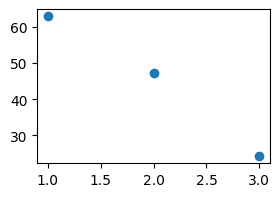

In [10]:
plt.figure(figsize=(3,2))
plt.scatter([1,2,3], pclass_survived_ratio)

seeing above result, there seems to be a linear relationship between the survival rate and the value of the Pclass. So we can keep Pclass as-is.

## Binning
For the Age column we can create bins of 0-10, 11-20, ... and make each bin a catagory using one-hot.

In [11]:
preproc_data['Age'].max()

80.0

In [12]:
bins = [i for i in range(0, 81, 10)] # bin boundries
binned_ages = pd.cut(preproc_data['Age'], bins).rename('Binned_age')
preproc_data = pd.concat([preproc_data,
                          pd.get_dummies(binned_ages, prefix='Binned_age' )],
                         axis=1)
preproc_data = preproc_data.drop(['Age'], axis=1)
preproc_data

,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,...,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,False,True,False,...,True,False,False,False,True,False,False,False,False,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,True,False,False,...,True,False,False,False,True,False,False,False,False,False
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,True,False,False,...,True,False,False,False,False,True,False,False,False,False
5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,False,True,False,...,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,0,211536,13.0000,False,True,False,...,True,False,False,False,True,False,False,False,False,False
888,1,1,"Graham, Miss. Margaret Edith",0,0,112053,30.0000,True,False,False,...,True,False,False,True,False,False,False,False,False,False
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2,W./C. 6607,23.4500,True,False,False,...,True,False,False,False,True,False,False,False,False,False


## Drop columns

In [13]:
preproc_data

,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,...,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,False,True,False,...,True,False,False,False,True,False,False,False,False,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,True,False,False,...,True,False,False,False,True,False,False,False,False,False
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,True,False,False,...,True,False,False,False,False,True,False,False,False,False
5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,False,True,False,...,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,0,211536,13.0000,False,True,False,...,True,False,False,False,True,False,False,False,False,False
888,1,1,"Graham, Miss. Margaret Edith",0,0,112053,30.0000,True,False,False,...,True,False,False,True,False,False,False,False,False,False
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2,W./C. 6607,23.4500,True,False,False,...,True,False,False,False,True,False,False,False,False,False


In [14]:
# passenger name and ticket numbers are unique per record anyway,
# so they can be dropped.
preproc_data = preproc_data.drop(['Name', 'Ticket'], axis=1)

In [15]:
preproc_data

,Survived,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,1,0,7.2500,False,True,False,False,True,False,False,False,True,False,False,False,False,False
2,1,1,1,0,71.2833,True,False,True,False,False,False,False,False,False,True,False,False,False,False
3,1,3,0,0,7.9250,True,False,False,False,True,False,False,False,True,False,False,False,False,False
4,1,1,1,0,53.1000,True,False,False,False,True,False,False,False,False,True,False,False,False,False
5,0,3,0,0,8.0500,False,True,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,0,13.0000,False,True,False,False,True,False,False,False,True,False,False,False,False,False
888,1,1,0,0,30.0000,True,False,False,False,True,False,False,True,False,False,False,False,False,False
889,0,3,1,2,23.4500,True,False,False,False,True,False,False,False,True,False,False,False,False,False


In [16]:
# index=None drops the passengerId which is index col
preproc_data.to_csv('./data/preprocessed_titanic_data.csv', index=None)

# Training Model

## Splitting dataset

In [17]:
data = pd.read_csv('./data/preprocessed_titanic_data.csv')
data

,Survived,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
0,0,3,1,0,7.2500,False,True,False,False,True,False,False,False,True,False,False,False,False,False
1,1,1,1,0,71.2833,True,False,True,False,False,False,False,False,False,True,False,False,False,False
2,1,3,0,0,7.9250,True,False,False,False,True,False,False,False,True,False,False,False,False,False
3,1,1,1,0,53.1000,True,False,False,False,True,False,False,False,False,True,False,False,False,False
4,0,3,0,0,8.0500,False,True,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,13.0000,False,True,False,False,True,False,False,False,True,False,False,False,False,False
887,1,1,0,0,30.0000,True,False,False,False,True,False,False,True,False,False,False,False,False,False
888,0,3,1,2,23.4500,True,False,False,False,True,False,False,False,True,False,False,False,False,False
889,1,1,0,0,30.0000,False,True,True,False,False,False,False,False,True,False,False,False,False,False


In [18]:
features = data.drop(['Survived'], axis=1)
labels = data['Survived']

In [19]:
from sklearn.model_selection import train_test_split

# want 60% training, 20% validation, 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [20]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((534, 18), (179, 18), (178, 18), (534,), (179,), (178,))

## Train several models
We'll train four models:

* Logistic regression (perceptron)
* Decision tree
* Naive Bayes
* Support vector machine (SVM)

In [21]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [24]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [25]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

AdaBoostClassifier()

In [29]:
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]

## Evaluating models

**Accuracy** = no. of correct pred / total no. of data points

**Recall** = TP / (TP+FN).

**Precision** = TP / (TP+FP)

**F1-score** = harmonic mean of precision and recall (i.e. a number between those two values but closer to the smaller one).

In [38]:
type(lr_model).__name__

'LogisticRegression'

In [47]:
from sklearn.metrics import f1_score, recall_score, precision_score

names = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for model in models:
  name = type(model).__name__
  accuracy = model.score(X_val, y_val)
  y_hat = model.predict(X_val)
  precision = precision_score(y_val, y_hat)
  recall = recall_score(y_val, y_hat)
  f1 = f1_score(y_val, y_hat)

  names.append(name)
  accuracies.append(accuracy)
  f1_scores.append(f1)
  precisions.append(precision)
  recalls.append(recall)

df_models_val = pd.DataFrame(
    {
        'Model': names,
        'Accuracy': accuracies,
        'F1 score': f1_scores,
        'Precision': precisions,
        'Recall': recalls,
    }
)
df_models_val.sort_values(['Accuracy'], ascending=False)

,Model,Accuracy,F1 score,Precision,Recall
1,DecisionTreeClassifier,0.808989,0.750000,0.772727,0.728571
5,GradientBoostingClassifier,0.808989,0.738462,0.800000,0.685714
4,RandomForestClassifier,0.797753,0.727273,0.774194,0.685714
0,LogisticRegression,0.769663,0.696296,0.723077,0.671429
2,GaussianNB,0.758427,0.715232,0.666667,0.771429
6,AdaBoostClassifier,0.730337,0.661972,0.652778,0.671429
3,SVC,0.685393,0.404255,0.791667,0.271429


## Testing models

In [48]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

names = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for model in models:
  name = type(model).__name__
  y_hat = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_hat)
  precision = precision_score(y_test, y_hat)
  recall = recall_score(y_test, y_hat)
  f1 = f1_score(y_test, y_hat)

  names.append(name)
  accuracies.append(accuracy)
  f1_scores.append(f1)
  precisions.append(precision)
  recalls.append(recall)

df_models_test = pd.DataFrame(
    {
        'Model': names,
        'Accuracy': accuracies,
        'F1 score': f1_scores,
        'Precision': precisions,
        'Recall': recalls,
    }
)
df_models_test.sort_values(['Accuracy'], ascending=False)

,Model,Accuracy,F1 score,Precision,Recall
5,GradientBoostingClassifier,0.787709,0.724638,0.735294,0.714286
6,AdaBoostClassifier,0.765363,0.695652,0.705882,0.685714
0,LogisticRegression,0.765363,0.695652,0.705882,0.685714
4,RandomForestClassifier,0.748603,0.685315,0.671233,0.700000
2,GaussianNB,0.748603,0.693878,0.662338,0.728571
1,DecisionTreeClassifier,0.743017,0.680556,0.662162,0.700000
3,SVC,0.642458,0.319149,0.625000,0.214286


## Hyperparam tuning with GridSearch

GridSearchCV where CV stands for Cross-Validation. The *k-fold cross validation* is an alternative to training-validation-testing method. It allows the same dataset to be used for training, validation:
1. split data into k equal portions
2. use the *k*th portion as the validation set, the rest as the training set.
3. the final score = average of all the k scores. i.e. $\frac{1}{k}\sum_{i=1}^{k}{score_i}$

In [52]:
from sklearn.model_selection import GridSearchCV

svm_params = {
    'kernel': ['rbf'],
    'C': [0.01, .1, 1, 10, 100],
    'gamma': [.01, .1, 1, 10, 100],
}
svm = SVC()
svm_gs = GridSearchCV(estimator = svm, param_grid=svm_params)
svm_gs.fit(X_train, y_train)

svm_winner = svm_gs.best_estimator_
svm_winner.score(X_val, y_val)

0.7696629213483146

In [53]:
svm_winner

SVC(C=10, gamma=0.01)

In [54]:
svm_gs.cv_results_

{'mean_fit_time': array([0.03907647, 0.02577305, 0.02143955, 0.02292404, 0.01740427,
        0.02391953, 0.02254753, 0.01973925, 0.02095504, 0.02355442,
        0.01474748, 0.01946206, 0.02745562, 0.02061911, 0.033319  ,
        0.01984158, 0.02183595, 0.03667626, 0.02255511, 0.0216557 ,
        0.03402133, 0.03940563, 0.04139166, 0.02706428, 0.02698913]),
 'std_fit_time': array([0.01419289, 0.01163481, 0.00594177, 0.00843109, 0.00038042,
        0.00658902, 0.00579721, 0.0056999 , 0.00397207, 0.00782689,
        0.00031504, 0.00424223, 0.00990229, 0.00271911, 0.01622163,
        0.0075219 , 0.00242668, 0.0097365 , 0.00396013, 0.00126213,
        0.01032072, 0.01733022, 0.0126639 , 0.00553431, 0.0075742 ]),
 'mean_score_time': array([0.02783298, 0.01300821, 0.01115341, 0.00933151, 0.00988975,
        0.01597638, 0.01675949, 0.01080456, 0.01057272, 0.01128287,
        0.00836711, 0.00948777, 0.01240678, 0.00855541, 0.01220617,
        0.00661526, 0.00687032, 0.01582713, 0.01044021, 0.00

# Neural Network

In [58]:
X_train.shape

(534, 18)

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(X_train.shape[1], 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.output(x)
    return F.sigmoid(x)

In [128]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

batch_size = 10
cat_y_train = F.one_hot(torch.tensor(y_train.values, dtype=torch.long), 2)
train_set = TensorDataset(torch.Tensor(X_train.to_numpy(dtype=np.float32)),
                          cat_y_train)
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [104]:
from tqdm.notebook import trange, tqdm

nn_model = SimpleNN()
criterion = nn.BCELoss() # nn.CrossEntropyLoss()
optimiser = optim.Adam(nn_model.parameters(), lr=0.0005)

n_epochs = 100
for epoch in range(1, n_epochs+1):
  nn_model.train()

  pbar = tqdm(dataloader, desc=f'Epoch {epoch}', leave=False)
  for features, labels in pbar:
    preds = nn_model(features)
    loss = criterion(preds, labels)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  if epoch%10==0:
    print(f'Epoch {epoch}/{n_epochs}: loss={loss:.4f}')


Epoch 1:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/100: loss=0.5052


Epoch 11:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/100: loss=0.2675


Epoch 21:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30/100: loss=0.5728


Epoch 31:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 40/100: loss=0.7334


Epoch 41:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 50/100: loss=0.4599


Epoch 51:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 60/100: loss=0.1109


Epoch 61:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 70/100: loss=0.3060


Epoch 71:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 80/100: loss=0.9081


Epoch 81:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 90/100: loss=0.9371


Epoch 91:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 100/100: loss=0.2634
